# Simulating Requests to an AI Prediction Deployed Model



## Setup

In [4]:
import os
from tensorflow import io as tf_io
import matplotlib.pyplot as plt
import numpy as np

In [5]:
PROJECT = 'mlops-dev-env'
GCS_DATA_LOCATION = 'gs://workshop-datasets/covertype/data_validation'
REGION = 'us-central1'
LOCAL_WORKSPACE = './data_staging'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
LOCAL_DATA_FILE = os.path.join(LOCAL_DATA_DIR, 'train.csv')
MODEL_NAME = 'covertype_tf'
VERSION_NAME = 'v3'

In [6]:
!gcloud config set project {PROJECT}

Updated property [core/project].


## 1. Download Data

We use the [covertype](https://archive.ics.uci.edu/ml/datasets/covertype) from UCI Machine Learning Repository. The task is to Predict forest cover type from cartographic variables only. 

The dataset is preprocessed, split, and uploaded to uploaded to the `gs://workshop-datasets/covertype` public GCS location. 

We use this version of the preprocessed dataset in this notebook. For more information, see [Cover Type Dataset](https://github.com/GoogleCloudPlatform/mlops-on-gcp/tree/master/datasets/covertype)

In [7]:
if tf_io.gfile.exists(LOCAL_WORKSPACE):
  print("Removing previous workspace artifacts...")
  tf_io.gfile.rmtree(LOCAL_WORKSPACE)

print("Creating a new workspace...")
tf_io.gfile.makedirs(LOCAL_WORKSPACE)
tf_io.gfile.makedirs(LOCAL_DATA_DIR)

Removing previous workspace artifacts...
Creating a new workspace...


In [8]:
!gsutil cp gs://workshop-datasets/covertype/data_validation/training/dataset.csv {LOCAL_DATA_FILE}
!wc -l {LOCAL_DATA_FILE}

Copying gs://workshop-datasets/covertype/data_validation/training/dataset.csv...

Operation completed over 1 objects/22.2 MiB.                                     
431010 ./data_staging/data/train.csv


In [9]:
import pandas as pd
data = pd.read_csv(LOCAL_DATA_FILE)
print("Total number of records: {}".format(len(data.index)))
data.sample(10).T

Total number of records: 431009


,330251,146571,222046,292788,150728,85067,276641,319593,72494,171900
Elevation,2667,3072,2548,2624,3021,2558,2942,3142,2740,3208
Aspect,119,345,28,183,153,320,313,289,30,45
Slope,8,18,20,38,4,14,9,9,17,6
Horizontal_Distance_To_Hydrology,95,192,90,30,309,30,150,120,450,108
Vertical_Distance_To_Hydrology,25,43,20,14,50,11,6,16,59,-2
Horizontal_Distance_To_Roadways,1536,778,547,2106,2460,1052,4306,1528,3275,4006
Hillshade_9am,235,183,208,201,225,183,197,194,212,222
Hillshade_Noon,233,210,192,233,240,226,234,239,200,227
Hillshade_3pm,129,164,113,131,150,182,177,185,119,140
Horizontal_Distance_To_Fire_Points,6498,1871,3144,511,484,5058,5102,631,2837,3534


## 2. Define Metadata

In [10]:
HEADER = ['Elevation', 'Aspect', 'Slope','Horizontal_Distance_To_Hydrology',
          'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
          'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
          'Cover_Type']

TARGET_FEATURE_NAME = 'Cover_Type'

FEATURE_LABELS = ['0', '1', '2', '3', '4', '5', '6']

NUMERIC_FEATURE_NAMES = ['Aspect', 'Elevation', 'Hillshade_3pm', 
                         'Hillshade_9am', 'Hillshade_Noon', 
                         'Horizontal_Distance_To_Fire_Points',
                         'Horizontal_Distance_To_Hydrology',
                         'Horizontal_Distance_To_Roadways','Slope',
                         'Vertical_Distance_To_Hydrology']

CATEGORICAL_FEATURE_NAMES = ['Soil_Type', 'Wilderness_Area']

FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES + NUMERIC_FEATURE_NAMES

HEADER_DEFAULTS = [[0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ['NA'] 
                   for feature_name in HEADER]

NUM_CLASSES = len(FEATURE_LABELS)

#### create a container for the serving data

In [11]:
serving_data = {
    '2020-04-01': None,
    '2020-04-02': None,
    '2020-04-03': None,
    '2020-04-04': None,
    '2020-04-05': None,
    '2020-04-06': None,
}

## 3. Sampling Unskewed Data

* Sample data for *three* consecutive dates: **01-04-20202**, **02-04-2020**, and **03-04-2020**
* Each day has 1000 examples
* No altering is applied



In [12]:
data_normal = data.sample(3000)

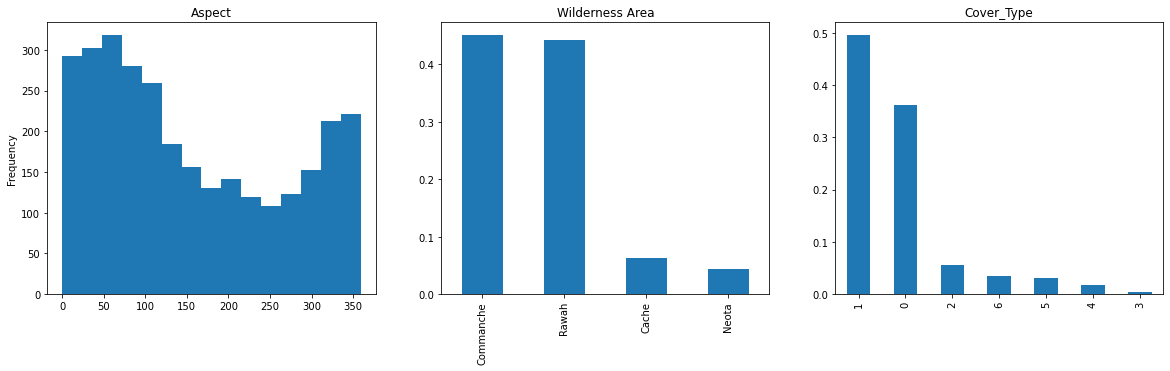

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
data_normal['Aspect'].plot.hist(bins=15, ax=axes[0], title='Aspect')
data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area')
data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[2], title=TARGET_FEATURE_NAME)

In [14]:
normal_days_data_list =[
                        data_normal[:1000],
                        data_normal[1000:2000],
                        data_normal[2000:]
]


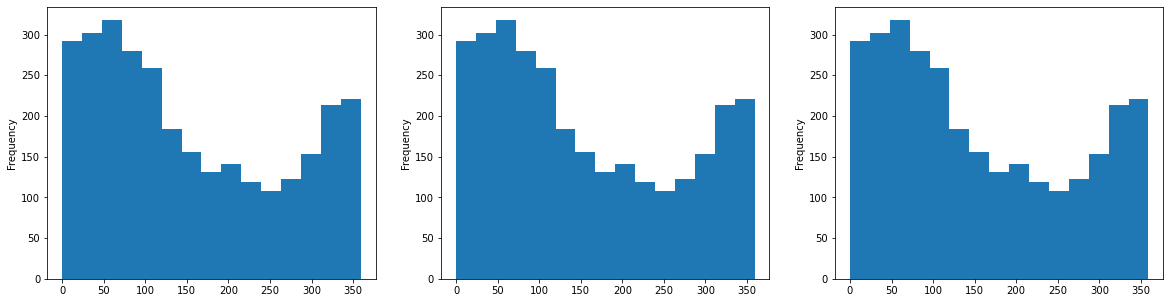

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Aspect'].plot.hist(bins=15, ax=axes[i])

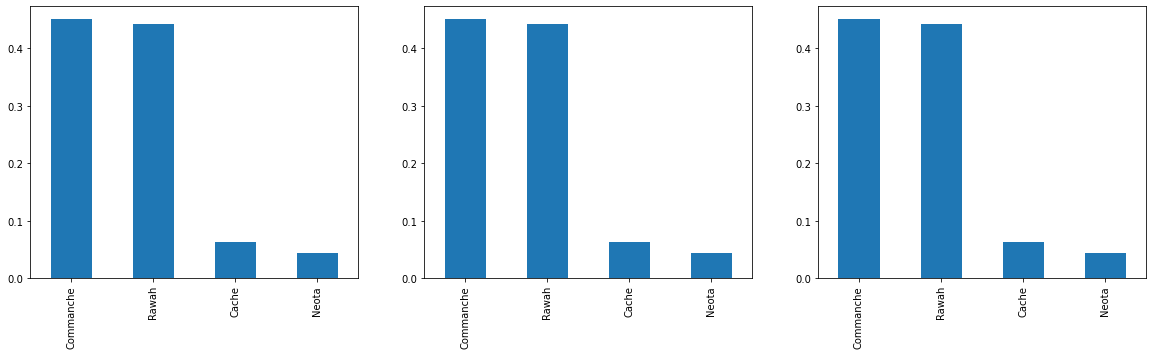

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[i])

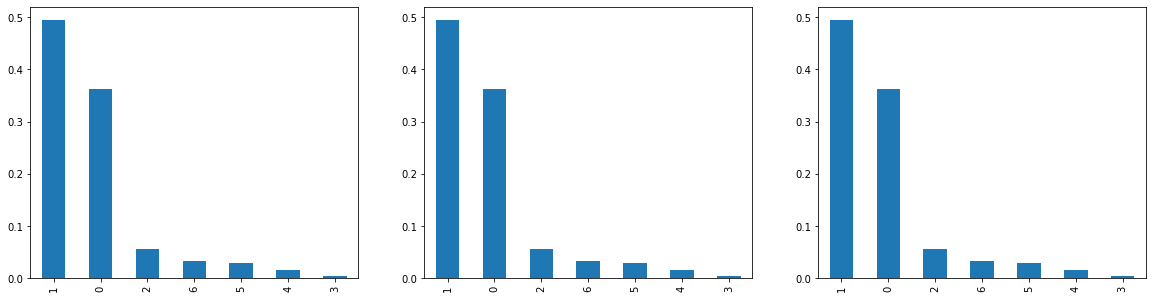

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, day_data in enumerate(normal_days_data_list):
  data_normal[TARGET_FEATURE_NAME].value_counts(normalize=True).plot.bar(ax=axes[i])

In [18]:
serving_data['2020-04-01'] = normal_days_data_list[0]
serving_data['2020-04-02'] = normal_days_data_list[1]
serving_data['2020-04-03'] = normal_days_data_list[2]

## 4. Preparing Skewed Data
We are going to introduce the following skews to the data:
1. **Numerical Features**
  1. *Elevation - Feature Skew*: Convert the unit of measure from meters to kilometers in 2020-04-05
  2. *Aspect - Distribution Skew*: gradual decrease of the value

2. **Categorical Features**
  1. *Wilderness_Area - Feature Skew*: Adding a new category "Others" in 2020-04-05
  2. *Wilderness_Area - Distribution Skew*: Gradual increase of of the frequency of "Cache" and "Neota" values
3. **Target Features**: check the change of the distribution of predictied class labels

In [19]:
data_to_skew = data.sample(3000)
serving_data['2020-04-04'] = data_to_skew[:1000]
serving_data['2020-04-05'] = data_to_skew[1000:2000]
serving_data['2020-04-06'] = data_to_skew[2000:]

### 4.1 Skew numerical features

#### 4.1.1 Elevation Feature Skew

In [20]:
serving_data['2020-04-05']['Elevation'] = serving_data['2020-04-05']['Elevation'] / 1000

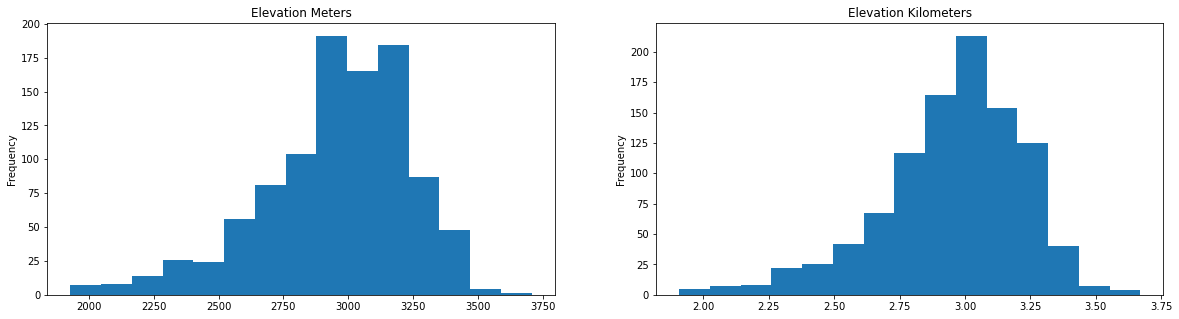

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
serving_data['2020-04-01']['Elevation'].plot.hist(bins=15, ax=axes[0], title='Elevation Meters')
serving_data['2020-04-05']['Elevation'].plot.hist(bins=15, ax=axes[1], title='Elevation Kilometers')

#### 4.1.2 Aspect Distribution Skew

In [22]:
serving_data['2020-04-04']['Aspect'] = serving_data['2020-04-04']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.90, 1) if value > 250 else value 
)

serving_data['2020-04-05']['Aspect'] = serving_data['2020-04-05']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.85, 1) if value > 250 else value 
)

serving_data['2020-04-06']['Aspect'] = serving_data['2020-04-06']['Aspect'].apply(
    lambda value: value * np.random.uniform(0.80, 1) if value > 250 else value 
)

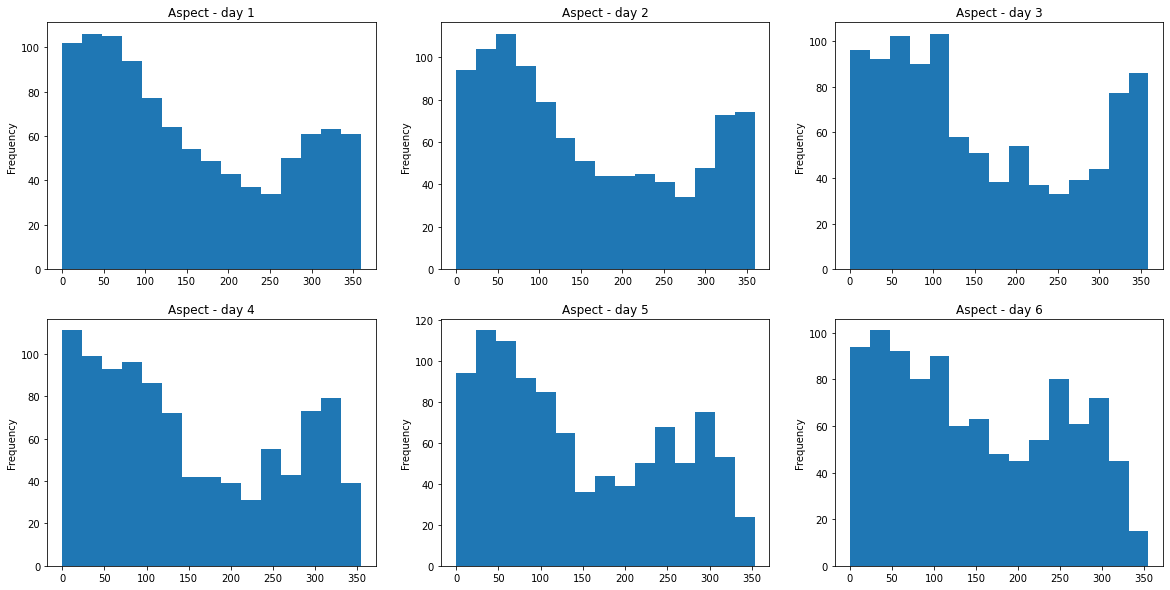

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Aspect'].plot.hist(bins=15, ax=axes[0, 0], title='Aspect - day 1')
serving_data['2020-04-02']['Aspect'].plot.hist(bins=15, ax=axes[0, 1], title='Aspect - day 2')
serving_data['2020-04-03']['Aspect'].plot.hist(bins=15, ax=axes[0, 2], title='Aspect - day 3')
serving_data['2020-04-04']['Aspect'].plot.hist(bins=15, ax=axes[1, 0], title='Aspect - day 4')
serving_data['2020-04-05']['Aspect'].plot.hist(bins=15, ax=axes[1, 1], title='Aspect - day 5')
serving_data['2020-04-06']['Aspect'].plot.hist(bins=15, ax=axes[1, 2], title='Aspect - day 6')

### 4.2 Skew categorical features

#### 4.2.1 Wilderness Area Feature Skew
Adding a new category "Others"


In [24]:
serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Others' if np.random.uniform() <= 0.1 else value
)

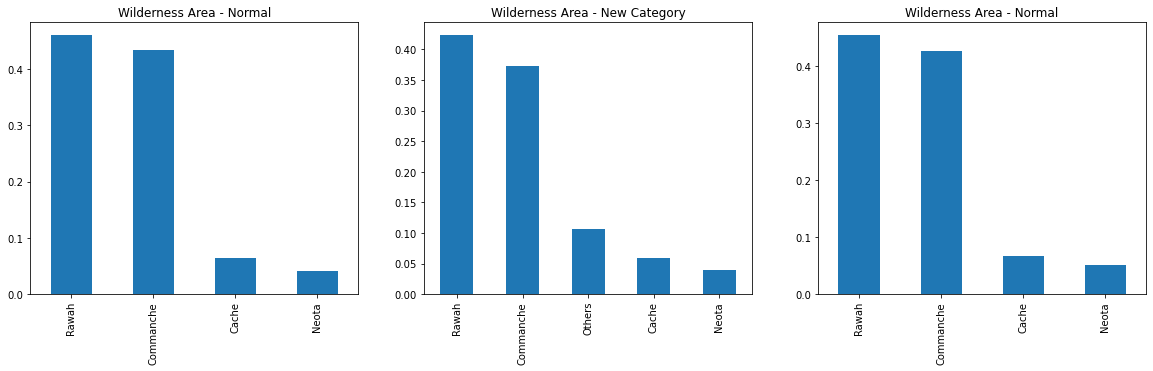

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0], title='Wilderness Area - Normal')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1], title='Wilderness Area - New Category')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[2], title='Wilderness Area - Normal')

#### 4.2.2 Wilderness Area Distribution Skew

In [26]:
serving_data['2020-04-04']['Wilderness_Area'] = serving_data['2020-04-04']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.1 else value
)

serving_data['2020-04-05']['Wilderness_Area'] = serving_data['2020-04-05']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.15 else value
)

serving_data['2020-04-06']['Wilderness_Area'] = serving_data['2020-04-06']['Wilderness_Area'].apply(
    lambda value: 'Neota' if value in ['Rawah', 'Commanche'] and np.random.uniform() <= 0.2 else value
)

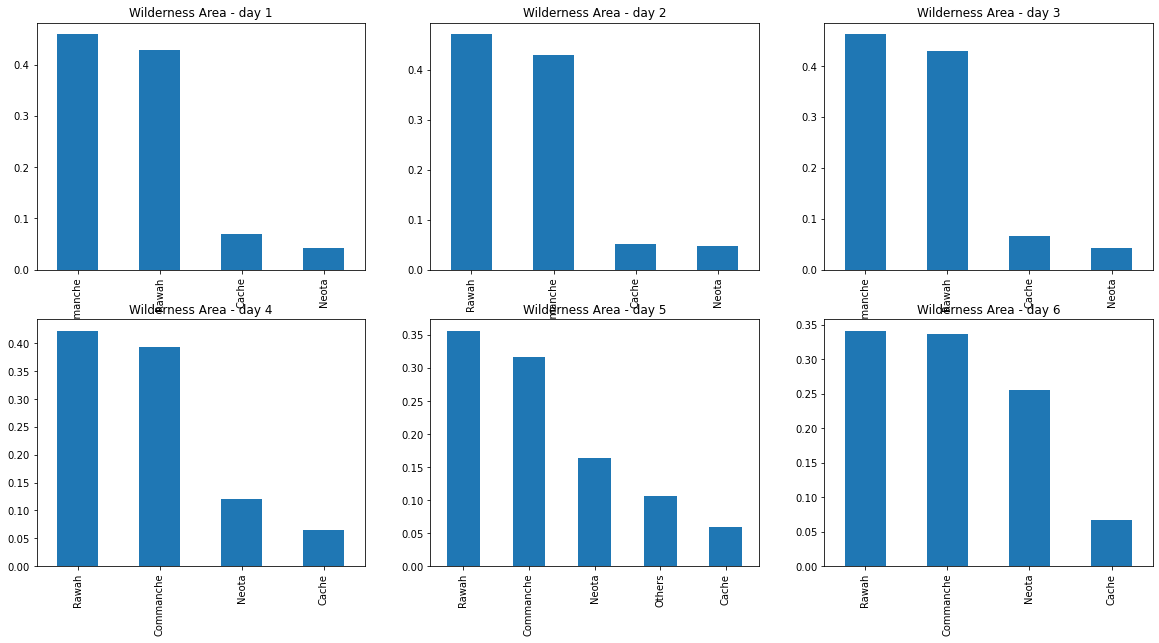

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
serving_data['2020-04-01']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 0], title='Wilderness Area - day 1')
serving_data['2020-04-02']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 1], title='Wilderness Area - day 2')
serving_data['2020-04-03']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[0, 2], title='Wilderness Area - day 3')
serving_data['2020-04-04']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 0], title='Wilderness Area - day 4')
serving_data['2020-04-05']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 1], title='Wilderness Area - day 5')
serving_data['2020-04-06']['Wilderness_Area'].value_counts(normalize=True).plot.bar(ax=axes[1, 2], title='Wilderness Area - day 6')


## 5. Simulating serving workload

In [28]:
from generate_predict_tasks import create_predict_task
from datetime import datetime
from datetime import timedelta

### 5.1 Convert all numeric features to floats

In [29]:
converted_serving_data = {}
for span in serving_data.keys():
    converted_serving_data[span] = (serving_data[span]
        .drop(['Soil_Type', 'Wilderness_Area', 'Cover_Type'], axis=1)
        .astype('float32'))

    converted_serving_data[span]['Soil_Type'] = serving_data[span]['Soil_Type'].astype('str')
    converted_serving_data[span]['Wilderness_Area'] = serving_data[span]['Wilderness_Area']

converted_serving_data['2020-04-01'].dtypes

Elevation                             float32
Aspect                                float32
Slope                                 float32
Horizontal_Distance_To_Hydrology      float32
Vertical_Distance_To_Hydrology        float32
Horizontal_Distance_To_Roadways       float32
Hillshade_9am                         float32
Hillshade_Noon                        float32
Hillshade_3pm                         float32
Horizontal_Distance_To_Fire_Points    float32
Soil_Type                              object
Wilderness_Area                        object
dtype: object

### 5.2 Schedule prediction tasks

In [37]:
start_time = datetime.fromisoformat('2020-05-22T20:00:00')

project = 'mlops-dev-env'
location = 'us-central1'
queue =  'caip-player'
model_name = 'covertype_tf'
model_version = 'v3'
service_account = "caipp-caller@mlops-dev-env.iam.gserviceaccount.com"
instances_per_call = 2
seconds_between_calls = 5


In [40]:
for span in converted_serving_data.keys():
    feature_dicts = converted_serving_data[span][0:4].to_dict(orient='record')
    instances = []
    start_time = start_time + timedelta(minutes=60)
    execute_time = start_time
    for feature_dict in feature_dicts:
        instances.append(feature_dict)
        if len(instances) == instances_per_call:
            execute_time = execute_time + timedelta(seconds = seconds_between_calls)
            print(execute_time)
            print(instances)
            instances = []
            


2020-05-23 04:00:05
[{'Elevation': 3326.0, 'Aspect': 43.0, 'Slope': 9.0, 'Horizontal_Distance_To_Hydrology': 511.0, 'Vertical_Distance_To_Hydrology': -10.0, 'Horizontal_Distance_To_Roadways': 1574.0, 'Hillshade_9am': 222.0, 'Hillshade_Noon': 220.0, 'Hillshade_3pm': 132.0, 'Horizontal_Distance_To_Fire_Points': 2065.0, 'Soil_Type': '8703', 'Wilderness_Area': 'Rawah'}, {'Elevation': 3025.0, 'Aspect': 45.0, 'Slope': 16.0, 'Horizontal_Distance_To_Hydrology': 564.0, 'Vertical_Distance_To_Hydrology': 211.0, 'Horizontal_Distance_To_Roadways': 875.0, 'Hillshade_9am': 223.0, 'Hillshade_Noon': 203.0, 'Hillshade_3pm': 110.0, 'Horizontal_Distance_To_Fire_Points': 938.0, 'Soil_Type': '7757', 'Wilderness_Area': 'Commanche'}]
2020-05-23 04:00:10
[{'Elevation': 2654.0, 'Aspect': 166.0, 'Slope': 15.0, 'Horizontal_Distance_To_Hydrology': 30.0, 'Vertical_Distance_To_Hydrology': 7.0, 'Horizontal_Distance_To_Roadways': 2022.0, 'Hillshade_9am': 232.0, 'Hillshade_Noon': 244.0, 'Hillshade_3pm': 139.0, 'Horizon

In [ ]:
#response = create_predict_task(
#        project=project,
#        queue=queue,
#        service_account=service_account,
#        location=location,
#        model_name=model_name,
#        model_version=model_version,
#        instances=instances,
#        execute_time=execute_time
#    )